In [1]:
import os
import boto3

import pandas as pd
import numpy as np

from sagemaker.session import Session

In [2]:
# asset classification for in/out of network
in_network_asset = ['Collateralized short-term financing agreements', 'Deposits with clearing organizations', 
                    'Receivable from broker-dealers', 'Receivable from parent and affiliates', 
                    'Receivables from customers and counterparties']

out_network_asset = ['Cash and cash equivalents', 'Cash and securities segregated for benefit of customers or regulations',
                     'Exchange memberships', 'Fixed assets', 'Intangible assets, net amortization', 
                     'PPE (net depreciation & amortization)', 'Receivable from employees', 'Time bank deposits',
                     'Deferred tax asset']

fifty_network_asset = ['Account receivable', 'Escrow account balances', 'Financial instruments owned, at fair value', 
                       'Other assets', 'Other receivables', 'Prepaid expenses', 'U.S. government and government agency']

# liability & equity classification for in/out of network 
in_network_liable = ['Collateralized borrowing agreements', 'Financial instruments sold,  but not yet purchased at fair value',
                     'Payable to banks', 'Payable to broker-dealers', 'Payable to customers and counterparties',
                     'Payable to parent and affiliates']

out_network_liable = ['Deferred liability', 'Lease liability', 'Taxes payable']

fifty_network_liable = ['Accounts payable', 'Accrued liabilities', 'Current liabilities', 'Long-term borrowing',
                       'Other liabilities', 'Short-term borrowing', 'Subordinated liabilities']


In [3]:
# Amazon Textract client and Sagemaker session
s3 = boto3.client('s3')
session = Session()

bucket = 'ran-s3-systemic-risk'

# retrieving the asset and liability classification models from s3 bucket
s3.download_file(bucket, 'Output/structured_asset.csv', 'structured_asset.csv')
df1 = pd.read_csv('structured_asset.csv')
os.remove('structured_asset.csv')

s3.download_file(bucket, 'Output/structured_liability.csv', 'structured_liability.csv')
df2 = pd.read_csv('structured_liability.csv')
os.remove('structured_liability.csv')

In [5]:
# determing the in/out network assets and liability & equity terms 
df1['IN_NETWORK_ASSETS'] = df1[df1.columns[np.isin(df1.columns, in_network_asset)]].sum(axis=1)
df1['OUT_NETWORK_ASSETS'] = df1[df1.columns[np.isin(df1.columns, out_network_asset)]].sum(axis=1)

df2['IN_NETWORK_LIABLE'] = df2[df2.columns[np.isin(df2.columns, in_network_liable)]].sum(axis=1)
df2['OUT_NETWORK_LIABLE'] = df2[df2.columns[np.isin(df2.columns, out_network_liable)]].sum(axis=1)

In [6]:
# select subsmaple for columsn to report back and merge
a = df1[['CIK', 'Name', 'Filing Date', 'Filing Year', 'IN_NETWORK_ASSETS', 'OUT_NETWORK_ASSETS']]
b = df2[['CIK', 'Name', 'Filing Date', 'Filing Year', 'IN_NETWORK_LIABLE', 'OUT_NETWORK_LIABLE']]

In [11]:
# merge the liability and equity dataframe with the asset dataframe 
c = pd.merge(a, b, on=['CIK', 'Name', 'Filing Date', 'Filing Year'])

<AxesSubplot:xlabel='Filing Year'>

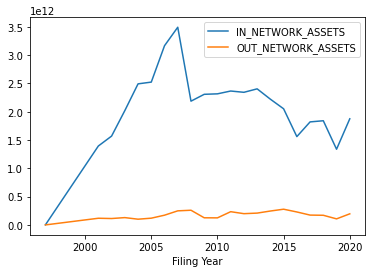

In [17]:
c.groupby('Filing Year')[['IN_NETWORK_ASSETS', 'OUT_NETWORK_ASSETS']].sum().plot()